In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

from knobs_functions import *

In [30]:
# Read Todd's data
# which is a list with one entry per state-chamber-ensemble_type combination.
with open('redundancy3.jsonl', 'r', encoding='utf-8') as file:
    data = [json.loads(line) for line in file]

In [33]:
len(data), data[0].keys(), data[0]['file']

(315,
 dict_keys(['file', 'metadata', 'num_precincts', 'plan_frequencies', 'district_frequencies', 'districts', 'plans']),
 '/Users/todd/ensembles/MI_congress/MI_congress_T0.01_S0.75_R0_Vcut-edges-region-aware/MI_congress_T0.01_S0.75_R0_Vcut-edges-region-aware_ensemble.jsonl.xz')

In [ ]:
def fetch_redundancy_data(state, chamber, ensemble_type):
    """
    Fetches the redundancy data for a given state, chamber, and ensemble type (from 'redundancy3.sjsonl').
    Returns a dictionary mapping frequencies to counts.
    For example, {1: 238439, 2: 1759,...} means that 238439 districts appeared once in the ensemble, 1759 districts appeared twice, etc.
    """
    if chamber == 'congress':
        pop0 = '0.01'
        pop_minus = '0.005'
        pop_plus = '0.015'
    else:
        pop0 = '0.05'
        pop_minus = '0.025'
        pop_plus = '0.075'

    type0 = 'cut-edges-rmst'
    type1 = 'cut-edges-region-aware'
    county0 = '0.0'

    ensemble_dict = {
        'base0' : f'T{pop0}_S{county0}_R0_V{type0}',
        'base1' : f'T{pop0}_S{county0}_R1_V{type0}',
        'base2' : f'T{pop0}_S{county0}_R2_V{type0}',
        'base3' : f'T{pop0}_S{county0}_R3_V{type0}',
        'base4' : f'T{pop0}_S{county0}_R4_V{type0}',
        'pop_minus' : f'T{pop_minus}_S{county0}_R0_V{type0}',
        'pop_plus' : f'T{pop_plus}_S{county0}_R0_V{type0}',
        'ust' : f'T{pop0}_S{county0}_R0_Vcut-edges-ust',
        'distpair' : f'T{pop0}_S{county0}_R0_Vdistrict-pairs-rmst',
        'distpair_ust' : f'T{pop0}_S{county0}_R0_Vdistrict-pairs-ust',
        'reversible' : f'T{pop0}_S{county0}_R0_Vreversible',
        'county25' : f'T{pop0}_S{0.25}_R0_V{type1}',
        'county50' : f'T{pop0}_S{0.5}_R0_V{type1}',
        'county75' : f'T{pop0}_S{0.75}_R0_V{type1}',
        'county100' : f'T{pop0}_S{1.0}_R0_V{type1}',   
    }
    snipet = ensemble_dict[ensemble_type]

    filename = f'/Users/todd/ensembles/{state}_{chamber}/{state}_{chamber}_{snipet}/{state}_{chamber}_{snipet}_ensemble.jsonl.xz'

    index = [n for n in range(len(data)) if data[n]['file'] == filename]
    X = data[index[0]]['district_frequencies']
    Y = {int(a) :b for a,b in X.items()} # convert keys from str to int
    sorted_Y = {k: Y[k] for k in sorted(Y.keys(), reverse=True)}  # sort by keys
    return sorted_Y

In [104]:
def autocorr(a): # lag 1 autocorrelation of the given array
    return np.corrcoef(a[:-1], a[1:])[0,1]

my_score_list = ['Reock', 'Polsby-Popper', 'cut edges', 'Dem seats', 'efficiency gap', 'mean-median',
 'partisan bias', 'competitive districts', 'average margin', 'counties_split']

df = pd.DataFrame(columns=['state', 'chamber', 'num_districts', 'ensemble_type',
                            'ess_max', 'ess_avg', 'ess_autocorr'])

for state, chamber in state_chamber_list:
    k = num_seats_dict[(state, chamber)]
    for ensemble_type in ensemble_list + ['base0']:
        Y = fetch_redundancy_data(state, chamber, ensemble_type)
        Y1 = [a for a, b in Y.items() for _ in range(b)]
        S = sum(Y1)//k # ensemble size
        ss_max = S//max(Y1)
        ss_avg = S//np.mean(Y1)

        # compute ESS based on the autocorrelation
        ls = []
        for score in my_score_list:
            a = fetch_score_array(state, chamber, ensemble_type, score)
            n = len(a)
            auto = np.abs(autocorr(a))
            ls.append(auto)
        maxa = max(ls)
        ess_autocorr = n*(1 - maxa)/(1 + maxa)

        df.loc[len(df)] = [state, chamber, k, ensemble_type, ss_max, ss_avg, ess_autocorr]

In [105]:
df

,state,chamber,num_districts,ensemble_type,ess_max,ess_avg,ess_autocorr
0,FL,congress,28,pop_minus,32,19387.0,17864.491243
1,FL,congress,28,pop_plus,83,19473.0,17892.857184
2,FL,congress,28,distpair,82,19518.0,16989.607305
3,FL,congress,28,ust,62,19492.0,18064.450960
4,FL,congress,28,distpair_ust,98,19578.0,18417.551728
...,...,...,...,...,...,...,...
226,WI,lower,99,county25,85,19745.0,16760.198176
227,WI,lower,99,county50,5,19082.0,13688.588618
228,WI,lower,99,county75,1,17789.0,10378.188741
229,WI,lower,99,county100,1,17360.0,8916.772831


In [106]:
df.columns

Index(['state', 'chamber', 'num_districts', 'ensemble_type', 'ess_max',
       'ess_avg', 'ess_autocorr'],
      dtype='object')

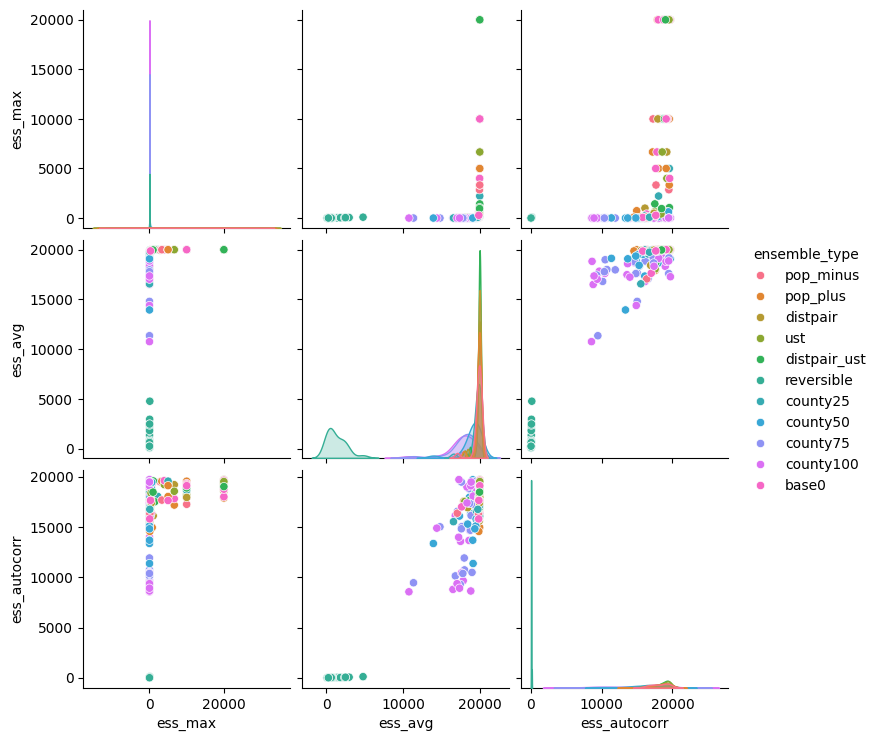

In [109]:
sns.pairplot(df[['ess_max','ess_avg','ess_autocorr', 'ensemble_type']], hue='ensemble_type')

In [110]:
df['ess_max'].describe()

count      231.000000
mean      4814.294372
std       7809.528347
min          1.000000
25%         12.000000
50%        105.000000
75%       8333.000000
max      20000.000000
Name: ess_max, dtype: float64

<Axes: xlabel='ess_max', ylabel='ensemble_type'>

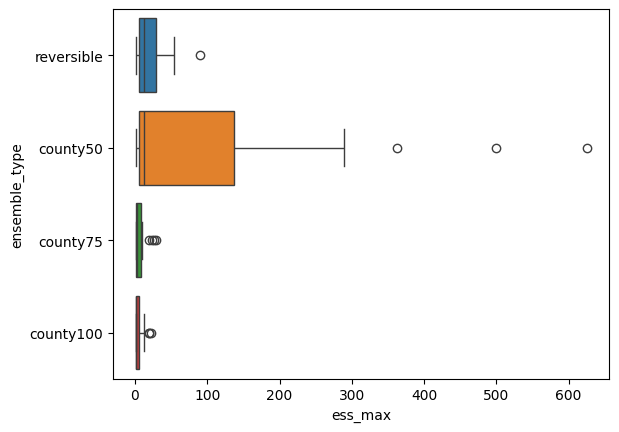

In [132]:
df1 = df[df['ensemble_type'].isin(['reversible', 'county50', 'county75','county100'])]
df2 = df[df['ensemble_type'].isin(['pop_minus', 'pop_plus', 'base0', 
                                   'county25', 'ust', 'distpair', 'distpair_ust'])]

sns.boxplot(df1, x='ess_max', y = 'ensemble_type', hue='ensemble_type')

<Axes: xlabel='ess_max', ylabel='ensemble_type'>

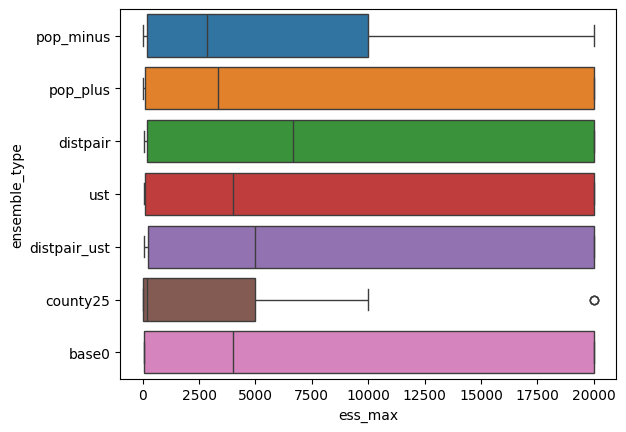

In [133]:
sns.boxplot(df2, x='ess_max', y = 'ensemble_type', hue='ensemble_type')

In [138]:
for ensemble_type in df['ensemble_type'].unique():
    df1 = df[df['ensemble_type'] == ensemble_type]
    print(f"{ensemble_type}: min={df1['ess_max'].min()}, avg={int(df1['ess_max'].mean())}")

pop_minus: min=21, avg=7045
pop_plus: min=31, avg=7243
distpair: min=71, avg=9058
ust: min=52, avg=8708
distpair_ust: min=79, avg=9041
reversible: min=1, avg=20
county25: min=7, avg=4220
county50: min=1, avg=109
county75: min=1, avg=7
county100: min=1, avg=5
base0: min=42, avg=7497


In [139]:
for ensemble_type in df['ensemble_type'].unique():
    df1 = df[df['ensemble_type'] == ensemble_type]
    print(f"{ensemble_type}: min={df1['ess_avg'].min()}, avg={int(df1['ess_avg'].mean())}")

pop_minus: min=17065.0, avg=19776
pop_plus: min=17920.0, avg=19823
distpair: min=18424.0, avg=19876
ust: min=18052.0, avg=19844
distpair_ust: min=18733.0, avg=19902
reversible: min=76.0, avg=1281
county25: min=16566.0, avg=19657
county50: min=13944.0, avg=18996
county75: min=11354.0, avg=17839
county100: min=10758.0, avg=17559
base0: min=17633.0, avg=19808


In [121]:
dfs = df[df['ensemble_type'] != 'reversible']

<Axes: xlabel='ess_max', ylabel='ess_autocorr'>

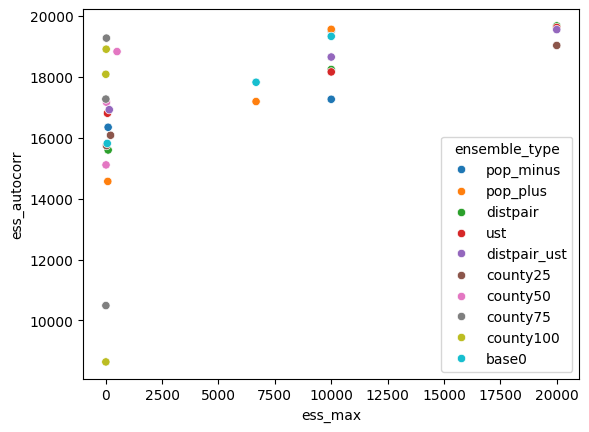

In [122]:
sns.scatterplot(x='ess_max', y='ess_autocorr', data=dfs[dfs['state'] == 'NY'], hue='ensemble_type')

<Axes: xlabel='ess_avg', ylabel='ess_autocorr'>

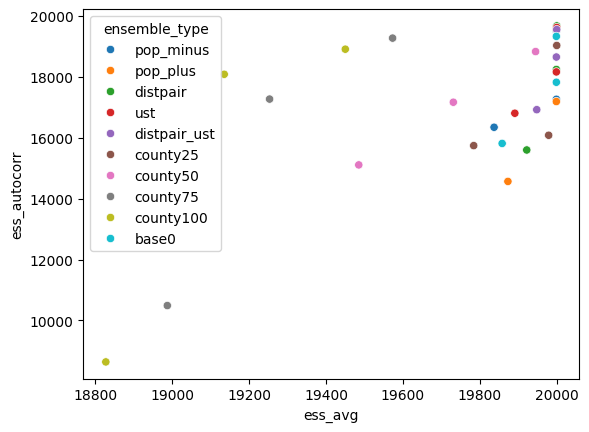

In [123]:
sns.scatterplot(x='ess_avg', y='ess_autocorr', data=dfs[dfs['state'] == 'NY'], hue='ensemble_type')

In [92]:
Y_rev = fetch_redundancy_data('NY', 'lower', 'reversible')
Y1_rev = [a for a, b in Y_rev.items() for _ in range(b)]
Y_c = fetch_redundancy_data('NY', 'lower', 'county100')
Y1_c = [a for a, b in Y_c.items() for _ in range(b)]

<Axes: ylabel='Count'>

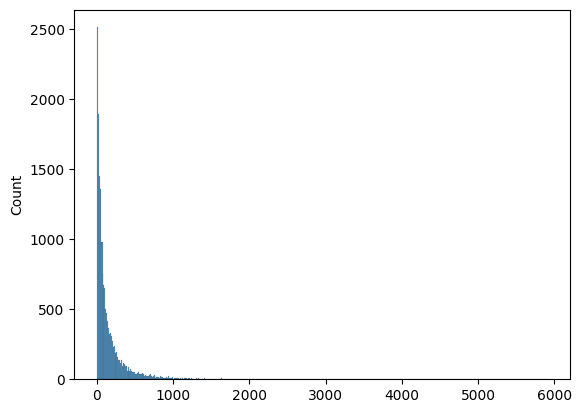

In [93]:
sns.histplot(Y1_rev)

<Axes: ylabel='Count'>

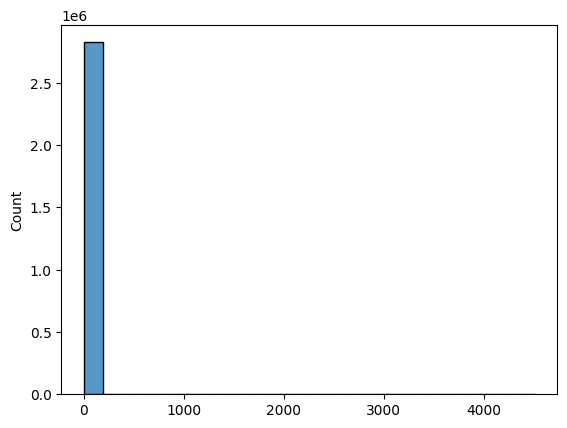

In [94]:
sns.histplot(Y1_c)

In [95]:
Y_rev

{5913: 1,
 5461: 1,
 5062: 1,
 4753: 1,
 4453: 1,
 3422: 1,
 3214: 1,
 3191: 1,
 3185: 1,
 3001: 1,
 2889: 1,
 2807: 1,
 2801: 1,
 2725: 1,
 2616: 1,
 2580: 1,
 2462: 1,
 2461: 1,
 2455: 1,
 2449: 1,
 2421: 1,
 2420: 1,
 2389: 1,
 2375: 1,
 2357: 1,
 2351: 1,
 2340: 1,
 2335: 1,
 2334: 1,
 2287: 1,
 2285: 1,
 2261: 1,
 2241: 1,
 2226: 1,
 2212: 1,
 2193: 1,
 2190: 1,
 2183: 1,
 2176: 1,
 2169: 1,
 2154: 1,
 2099: 1,
 2083: 1,
 2074: 1,
 2069: 1,
 2044: 3,
 2041: 1,
 2038: 1,
 2001: 1,
 1953: 1,
 1946: 1,
 1943: 1,
 1941: 1,
 1931: 1,
 1914: 1,
 1901: 1,
 1884: 1,
 1881: 1,
 1880: 1,
 1872: 1,
 1866: 1,
 1854: 1,
 1853: 1,
 1849: 1,
 1840: 1,
 1839: 1,
 1836: 1,
 1831: 1,
 1830: 1,
 1823: 1,
 1820: 1,
 1809: 1,
 1801: 1,
 1797: 1,
 1792: 1,
 1781: 1,
 1778: 1,
 1762: 1,
 1759: 1,
 1748: 1,
 1746: 1,
 1738: 1,
 1736: 1,
 1733: 1,
 1720: 1,
 1712: 1,
 1706: 1,
 1692: 1,
 1686: 1,
 1674: 1,
 1662: 1,
 1645: 1,
 1643: 1,
 1632: 1,
 1630: 1,
 1628: 1,
 1625: 1,
 1624: 1,
 1623: 1,
 1620: 1,


In [96]:
Y_c

{4509: 1,
 2992: 1,
 2558: 1,
 2445: 1,
 2211: 1,
 2022: 1,
 1575: 1,
 1067: 1,
 1011: 1,
 989: 1,
 902: 1,
 893: 1,
 838: 1,
 719: 1,
 710: 1,
 686: 1,
 683: 1,
 669: 1,
 644: 1,
 643: 1,
 515: 1,
 490: 1,
 486: 1,
 479: 1,
 476: 1,
 468: 1,
 450: 1,
 442: 1,
 427: 1,
 391: 1,
 384: 1,
 379: 1,
 376: 1,
 374: 1,
 364: 1,
 352: 2,
 351: 1,
 348: 1,
 339: 1,
 336: 1,
 330: 1,
 318: 1,
 313: 1,
 292: 1,
 283: 1,
 278: 1,
 276: 1,
 269: 1,
 265: 1,
 254: 1,
 250: 2,
 247: 1,
 246: 1,
 243: 1,
 242: 2,
 240: 1,
 236: 1,
 226: 1,
 222: 1,
 221: 1,
 220: 1,
 214: 1,
 212: 1,
 211: 1,
 210: 1,
 207: 1,
 205: 1,
 203: 1,
 201: 2,
 199: 1,
 197: 1,
 191: 1,
 189: 1,
 182: 2,
 180: 1,
 179: 2,
 177: 2,
 175: 2,
 168: 1,
 165: 1,
 164: 1,
 163: 2,
 160: 1,
 159: 1,
 158: 1,
 157: 1,
 156: 2,
 155: 1,
 154: 1,
 153: 2,
 152: 1,
 151: 1,
 148: 1,
 147: 3,
 142: 3,
 141: 2,
 140: 1,
 137: 1,
 136: 1,
 135: 1,
 131: 3,
 130: 1,
 128: 1,
 127: 1,
 125: 1,
 124: 2,
 123: 1,
 122: 2,
 121: 3,
 119: 2,
 

In [97]:
max(Y_rev.values()), max(Y_c.values())

(225, 2791340)

In [98]:
Y_rev[1], Y_c[1]

(217, 2791340)